<a href="https://colab.research.google.com/github/AArna1211/Traffic-prediction/blob/main/TP_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score # Importing mean_absolute_error and accuracy_score from sklearn.metrics
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_csv('/content/Traffic.csv')

In [3]:
data.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [5]:
# Convert Time & Date columns to datetime format
data["Timestamp"] = pd.to_datetime(data["Time"] + " " + data["Date"].astype(str))
data = data.sort_values(by="Timestamp")
data.set_index("Timestamp", inplace=True)

<ipython-input-5-d347e413b85b>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Timestamp"] = pd.to_datetime(data["Time"] + " " + data["Date"].astype(str))


In [6]:
# Encode categorical "Traffic Situation"
label_encoder = LabelEncoder()
data["Traffic Situation Encoded"] = label_encoder.fit_transform(data["Traffic Situation"])


In [16]:
# Define SARIMA model order (p, d, q) and seasonal order (P, D, Q, s)
p, d, q = 1, 1, 1  # ARIMA components
P, D, Q, s = 1, 1, 1, 4  # Seasonal components with seasonality period (adjustable)

In [17]:
# Split into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [18]:
# Fit SARIMA model
sarima_model = SARIMAX(data["Traffic Situation Encoded"], order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
result = sarima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


In [21]:
# Forecast on test set
forecast = result.get_forecast(steps=len(test))
test["Predicted"] = np.round(forecast.predicted_mean).astype(int)

# Instead of clipping, fill NaN with most frequent value before transforming
test['Predicted'] = test['Predicted'].fillna(test['Traffic Situation Encoded'].mode()[0]).astype(int)

#Ensure predicted values within the encoder's known range.
test["Predicted"] = test["Predicted"].clip(0, len(label_encoder.classes_) - 1)

# Decode labels
test["Predicted Traffic Situation"] = label_encoder.inverse_transform(test["Predicted"])

<ipython-input-21-45cdf8d01026>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicted"] = np.round(forecast.predicted_mean).astype(int)
<ipython-input-21-45cdf8d01026>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted'] = test['Predicted'].fillna(test['Traffic Situation Encoded'].mode()[0]).astype(int)
<ipython-input-21-45cdf8d01026>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Test Accuracy: 0.5705
Mean Absolute Error: 0.9765


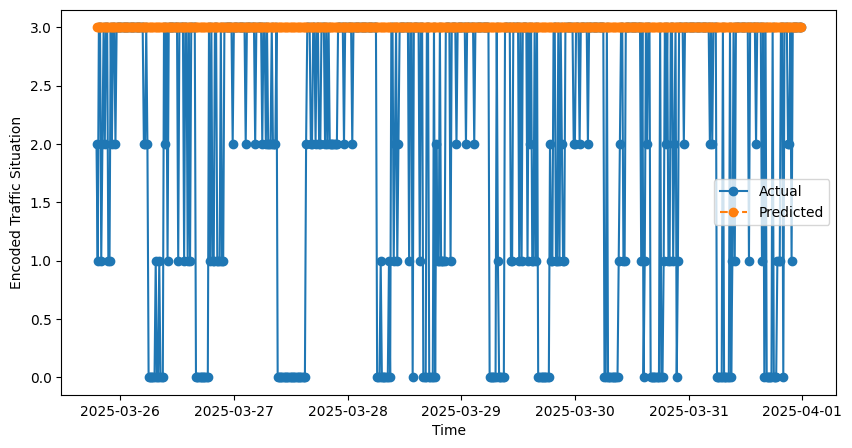

In [22]:
# Calculate accuracy
accuracy = accuracy_score(test["Traffic Situation Encoded"], test["Predicted"])
mae = mean_absolute_error(test["Traffic Situation Encoded"], test["Predicted"])
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(test.index, test["Traffic Situation Encoded"], label="Actual", marker='o')
plt.plot(test.index, test["Predicted"], label="Predicted", linestyle='dashed', marker='o')
plt.xlabel("Time")
plt.ylabel("Encoded Traffic Situation")
plt.legend()
plt.show()
